In [231]:
import numpy as np
import keras
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

In [232]:
def measure_metrics(X_train, X_test, y_train, y_test, regressor, scaler_y):
    y_pred = scaler_y.inverse_transform(regressor.predict(X_test))
    mse_test = root_mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    e_var_test = explained_variance_score(y_test, y_pred)
    # Training data
    y_pred_train = scaler_y.inverse_transform(regressor.predict(X_train))
    mse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    e_var_train = explained_variance_score(y_train, y_pred_train)
    
    print("Best model on test data:")
    print("Normalized Root Mean Squared Error:", mse_test /(np.max(y_test) - np.min(y_test)))   
    print("R-squared:", r2_test)
    print("Mean Absolute Error:", mae_test)
    print("Explained Variance Score:", e_var_test)
    
    print("= = = = =")
    
    print("Best model on training data:")
    print("Root Mean Squared Error:", mse_train / (np.max(y_train) - np.min(y_train)))
    print("R-squared:", r2_train)
    print("Mean Absolute Error:", mae_train)
    print("Explained Variance Score:", e_var_train)

In [233]:
data = pd.read_csv('filtered_installations_with_weather.csv')
data['data'] = pd.to_datetime(data['data'])

# Now group by the month of the installation date and plot the 'efekt' for each installation id
data['month'] = data['data'].dt.to_period('M')
data['month'] = data['month'].dt.strftime('%m')
data['month'] = data['month'].str[-2:].astype(int)

data['hour'] = data['data'].dt.hour
data['hour'] = data['hour'].astype(int)

print(len(data))
data.head()

181306


,ID,power,index,longitude,latitude,data,dpv,p,efficiency,temperature,cloudiness,humidity,wind_speed,month,hour
0,11574,2200.0,6733.0,18.222229,54.486498,2020-01-01 08:00:00,104,2034,2.295000,1,10,93,23,1,8
1,11574,2200.0,6733.0,18.222229,54.486498,2020-01-01 09:00:00,192,3846,4.370000,1,10,96,24,1,9
2,11574,2200.0,6733.0,18.222229,54.486498,2020-01-01 10:00:00,174,3482,3.945000,2,91,94,29,1,10
3,11574,2200.0,6733.0,18.222229,54.486498,2020-01-01 11:00:00,216,4154,4.973684,2,91,94,29,1,11
4,11574,2200.0,6733.0,18.222229,54.486498,2020-01-01 12:00:00,148,2780,3.931250,3,91,92,32,1,12


In [234]:
X = data[['longitude', 'latitude', 'temperature', 'wind_speed', 'cloudiness', "month", "hour"]]
y = data['efficiency']

unique_ids = data['ID'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = data[data['ID'].isin(train_ids)]
test_df = data[data['ID'].isin(test_ids)]

X_train = train_df[['longitude', 'latitude', 'temperature', 'wind_speed', 'cloudiness', "month", "hour"]]
X_test = test_df[['longitude', 'latitude', 'temperature', 'wind_speed', 'cloudiness', "month", "hour"]]

y_train = train_df['efficiency']
y_test = test_df['efficiency']

print(test_ids, train_ids)

print(len(X_train))
print(len(X_test))

[100612  11695 100730  12016  11592  11479 100654] [100418  11537  11574  10343  11996  11079  11686  11529 100352     35
    185 100462  10020 100254 100541 100282  12094 100668 100068  11149
  11528  11694 100549  12102  11137]
137165
44141


In [235]:
from keras.src.callbacks import ReduceLROnPlateau
from keras.src.layers import BatchNormalization

model = keras.Sequential([
    keras.layers.Input(shape=[X_train.shape[1],]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

optimizer = keras.optimizers.Adam(learning_rate=0.05)

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=[keras.losses.MeanSquaredError()]
)
model.summary

<bound method Model.summary of <Sequential name=sequential_23, built=True>>

In [236]:
batch_size = 32
epochs = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="checkpoints/model_at_epoch_{epoch}.keras"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001),
    keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=5)
]

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.fit_transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_df['efficiency'].to_frame())
y_test_scaled = scaler_y.fit_transform(test_df['efficiency'].to_frame())

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)
score = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

Epoch 1/200
3430/3430 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - loss: 0.3908 - mean_squared_error: 0.3908 - val_loss: 0.3436 - val_mean_squared_error: 0.3436 - learning_rate: 0.0500
Epoch 2/200
3430/3430 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - loss: 0.3325 - mean_squared_error: 0.3325 - val_loss: 0.2989 - val_mean_squared_error: 0.2988 - learning_rate: 0.0500
Epoch 3/200
3430/3430 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step - loss: 0.3143 - mean_squared_error: 0.3143 - val_loss: 0.2865 - val_mean_squared_error: 0.2864 - learning_rate: 0.0500
Epoch 4/200
3430/3430 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - loss: 0.3120 - mean_squared_error: 0.3120 - val_loss: 0.2710 - val_mean_squared_error: 0.2709 - learning_rate: 0.0500
Epoch 5/200
3430/3430 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.3853 - val_mean_squared_error: 0.3851 - learning_rate: 0.0500
Epoch 6/200
3430/3430 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step - loss: 0.3133 - mean_squared_error: 0.3133 - val_loss: 0.

In [237]:
measure_metrics(X_train_scaled, X_test_scaled, y_train, y_test, model, scaler_y)

1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step
Best model on test data:
Normalized Root Mean Squared Error: 0.11394178542958378
R-squared: 0.6981569478141618
Mean Absolute Error: 9.556834696205877
Explained Variance Score: 0.6981930345552515
= = = = =
Best model on training data:
Root Mean Squared Error: 0.11967691799694058
R-squared: 0.7290933099237276
Mean Absolute Error: 8.918447337039726
Explained Variance Score: 0.7292050039646913


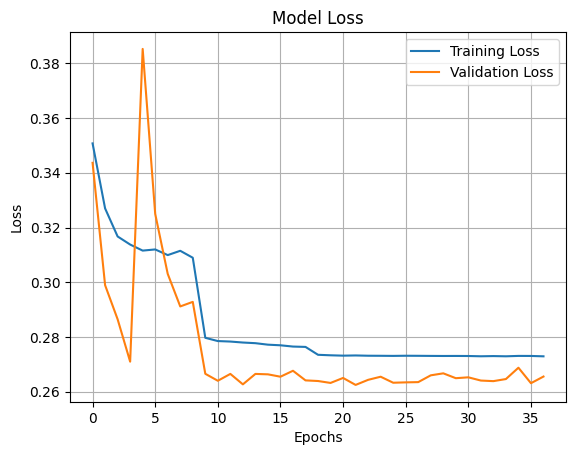

In [238]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


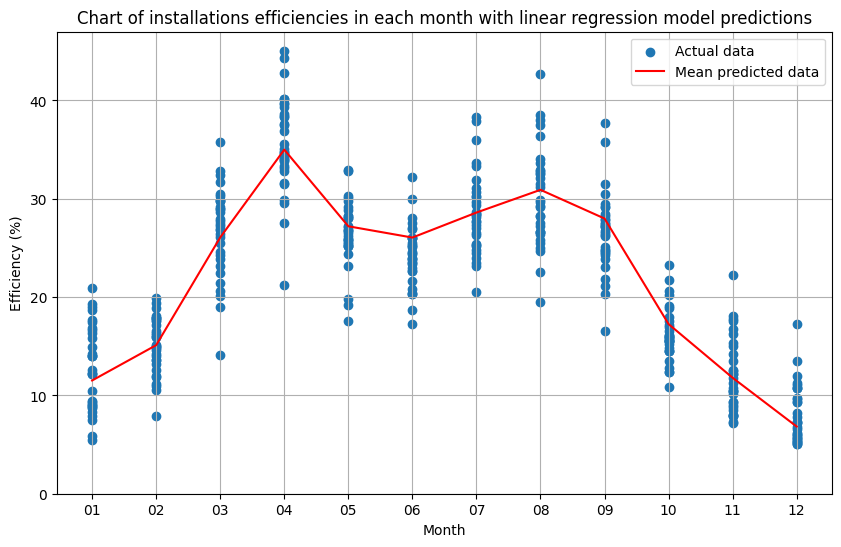

In [239]:
y_pred = scaler_y.inverse_transform(model.predict(X_test_scaled))
# Aggregate the data to get the average efficiency for each month
df = data.copy()
df['data'] = pd.to_datetime(df['data'])
df['month'] = df['data'].dt.to_period('M')
df_grouped = df.groupby(['ID', 'month']).mean()['efficiency']
df_grouped = df_grouped.reset_index()
df_grouped['month'] = df_grouped['month'].dt.strftime('%m')

# Aggregate data with predicted values
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['efficiency'] = y_pred
X_test_df['month'] = pd.to_datetime(X_test_df['month'], format='%m').dt.to_period('M')
X_df_grouped = X_test_df.groupby(['month']).mean()['efficiency']
X_df_grouped = X_df_grouped.reset_index()
X_df_grouped['month'] = X_df_grouped['month'].dt.strftime('%m')

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df_grouped['month'], df_grouped['efficiency'])
plt.plot(X_df_grouped['month'], X_df_grouped['efficiency'], color='red')
plt.title("Chart of installations efficiencies in each month with linear regression model predictions")
plt.xlabel("Month")
plt.ylabel("Efficiency (%)")

plt.xticks(range(int(df_grouped['month'].min()) - 1, int(df_grouped['month'].max()), 1))
plt.yticks(range(0, int(df_grouped['efficiency'].max()) + 1, 10))
plt.legend(["Actual data", "Mean predicted data"])

plt.grid(True)

4287/4287 ━━━━━━━━━━━━━━━━━━━━ 1s 298us/step


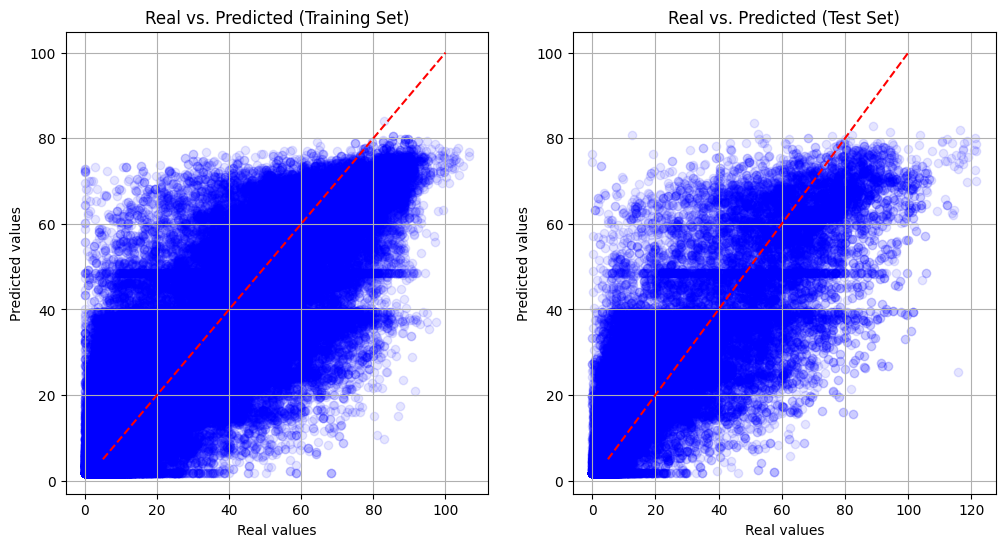

In [240]:
y_pred_train = scaler_y.inverse_transform(model.predict(X_train_scaled))

# Wykresy do oceny modelu
plt.figure(figsize=(12, 6))

# Wykres rzeczywistych vs. przewidywanych wartości dla zbioru treningowego
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.1, color='blue')
plt.plot([5, 100], [5, 100], color='red', linestyle='--')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Real vs. Predicted (Training Set)")
plt.grid(True)

# Wykres rzeczywistych vs. przewidywanych wartości dla zbioru testowego
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.1, color='blue')
plt.plot([5, 100], [5, 100], color='red', linestyle='--')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Real vs. Predicted (Test Set)")
plt.grid(True)

plt.show()